In [1]:
#Go to account in kaggle.create newapi token and json file is downloaded.upload it(find in downloads)
from google.colab import files

uploaded = files.upload()
print(uploaded) #{'kaggle.json': b'{"username":"raghavendraredd1","key":"a0cc13e433266c6685556806c4740de6"}'}
for fn in uploaded.keys():
  print("User uploaded file '{name}' with length {length} bytes".format(name=fn,length=len(uploaded[fn])))

#then move kaggle.json into folder where api expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
#Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.

Saving kaggle.json to kaggle.json
{'kaggle.json': b'{"username":"raghavendraredd1","key":"a0cc13e433266c6685556806c4740de6"}'}
User uploaded file 'kaggle.json' with length 72 bytes


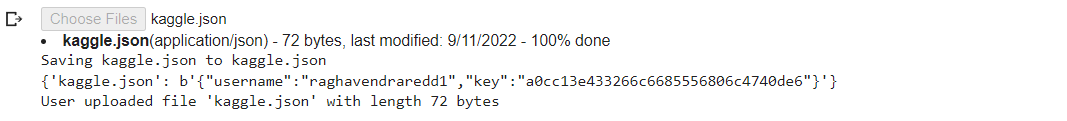

In [2]:
!kaggle datasets download -d deadskull7/fer2013 
#Copy API command

 99% 96.0M/96.6M [00:05<00:00, 22.3MB/s]
100% 96.6M/96.6M [00:05<00:00, 18.0MB/s]


In [3]:
!unzip fer2013.zip

Archive:  fer2013.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
!rm fer2013.zip

### Importing Required Libraries

In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.utils
from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
#import random
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input,GlobalMaxPooling2D
from keras.models import Model
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras import layers
from keras import applications
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [6]:
data=pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [8]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

### Missing Values Check

In [9]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [10]:
data.shape

(35887, 3)

### Data Distribution

In [11]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [12]:
class_labels=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

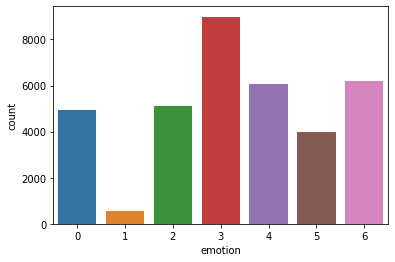

In [13]:
sns.countplot(data['emotion'])
plt.show()

In [14]:
y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])]
y

[4953, 547, 5121, 8989, 6077, 4002, 6198]

In [15]:
np.unique(data['emotion'])

array([0, 1, 2, 3, 4, 5, 6])

In [16]:
fig = px.bar(x = class_labels,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [14]:
train_data=data[data['Usage']=='Training']
train_data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


In [15]:
validation_data=data[data['Usage']=='PublicTest']
validation_data

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest
...,...,...,...
32293,4,178 176 172 173 173 174 176 173 166 166 206 22...,PublicTest
32294,3,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...,PublicTest
32295,4,255 255 255 255 255 255 255 255 255 255 255 25...,PublicTest
32296,4,33 25 31 36 36 42 69 103 132 163 175 183 187 1...,PublicTest


In [16]:
test_data=data[data['Usage']=='PrivateTest']
test_data

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [17]:
train_pixels = train_data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
train_pixels

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 74,  81,  87, ..., 188, 187, 187],
       [222, 227, 203, ..., 136, 136, 134],
       [195, 199, 205, ...,   6,  15,  38]], dtype=uint8)

In [18]:
train_labels = to_categorical(train_data['emotion'], num_classes=7)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [19]:
valid_labels = to_categorical(validation_data['emotion'], num_classes=7)
valid_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [20]:
test_labels = to_categorical(test_data['emotion'], num_classes=7)
test_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [21]:
valid_pixels = validation_data["pixels"].astype(str).str.split(" ").tolist()
valid_pixels = np.uint8(valid_pixels)
valid_pixels

array([[254, 254, 254, ...,  42, 129, 180],
       [156, 184, 198, ..., 172, 167, 161],
       [ 69, 118,  61, ...,  88,  87,  90],
       ...,
       [255, 255, 255, ...,  48,  50,  46],
       [ 33,  25,  31, ...,   4,   5,   4],
       [ 61,  63,  59, ..., 113, 165, 180]], dtype=uint8)

In [22]:
test_pixels = test_data["pixels"].astype(str).str.split(" ").tolist()
test_pixels = np.uint8(test_pixels)
test_pixels

array([[170, 118, 101, ..., 159, 133, 131],
       [  7,   5,   8, ...,  72,  57,  52],
       [232, 240, 241, ...,   4,   4,   9],
       ...,
       [ 17,  17,  16, ..., 154, 133, 113],
       [ 30,  28,  28, ...,  35,  30,  28],
       [ 19,  13,  14, ..., 189, 199, 201]], dtype=uint8)

In [23]:
train_pixels.shape,valid_pixels.shape,test_pixels.shape,train_labels.shape,valid_labels.shape,test_labels.shape

((28709, 2304), (3589, 2304), (3589, 2304), (28709, 7), (3589, 7), (3589, 7))

### Normalize the data

In [24]:
train_pixels=train_pixels/255
valid_pixels=valid_pixels/255
test_pixels=test_pixels/255


In [ ]:
'''train_pixels3 = train_pixels.reshape((35887*2304,1))
scaler = StandardScaler()
train_pixels3 = scaler.fit_transform(train_pixels3)
train_pixels3
train_pixels3 = train_pixels3.reshape((35887, 48, 48,1))
train_pixels3[:3]'''

In [25]:
import math
math.sqrt(len(data.pixels[0].split(' ')))

48.0

In [26]:
train_pixels = train_pixels.reshape((28709, 48, 48,1))
valid_pixels = valid_pixels.reshape((3589, 48, 48,1))
test_pixels = test_pixels.reshape((3589, 48, 48,1))

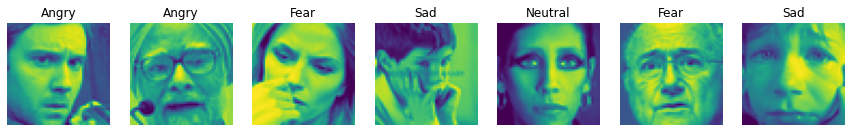

In [32]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(train_pixels[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(train_labels[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [27]:
traindatagen = ImageDataGenerator( width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range=0.2,
                               horizontal_flip = True,
                               vertical_flip=True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range=0.2,
                               horizontal_flip = True,
                               vertical_flip=True,
                               zoom_range = 0.2 ) 
testgen= ImageDataGenerator()

In [34]:
train_generator = traindatagen.flow(train_pixels, train_labels, batch_size=64)
val_generator = valgen.flow(valid_pixels,valid_labels, batch_size=64)
test_generator=testgen.flow(test_pixels,test_labels,batch_size=64)

In [35]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1))) #32*3*3+32
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' )) #64*9*32+64
  model.add(BatchNormalization()) #64*4
  #Just like the parameters (eg. weights, bias) of any network layer, a Batch Norm layer also has parameters of its own:

#Two learnable parameters called beta and gamma.
#Two non-learnable parameters (Mean Moving Average and Variance Moving Average) are saved as part of the ‘state’ of the Batch Norm layer.

  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu')) #128*5*5*64+128
  model.add(BatchNormalization()) #128*4
  model.add(MaxPool2D(pool_size=(2, 2))) 
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))) #512*3*3*128+512
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model
 

In [36]:
model=cnn_model()

In [37]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [28]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 15),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [40]:
history = model.fit(train_generator,
                    epochs=60,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/60
448/449 [============================>.] - ETA: 0s - loss: 14.0686 - accuracy: 0.1789
Epoch 1: val_accuracy improved from -inf to 0.23098, saving model to best_model.h5
449/449 [==============================] - 30s 44ms/step - loss: 14.0664 - accuracy: 0.1789 - val_loss: 12.9079 - val_accuracy: 0.2310
Epoch 2/60
448/449 [============================>.] - ETA: 0s - loss: 12.1343 - accuracy: 0.2051
Epoch 2: val_accuracy improved from 0.23098 to 0.23266, saving model to best_model.h5
449/449 [==============================] - 18s 41ms/step - loss: 12.1323 - accuracy: 0.2050 - val_loss: 10.9401 - val_accuracy: 0.2327
Epoch 3/60
448/449 [============================>.] - ETA: 0s - loss: 10.1500 - accuracy: 0.2102
Epoch 3: val_accuracy did not improve from 0.23266
449/449 [==============================] - 19s 41ms/step - loss: 10.1480 - accuracy: 0.2102 - val_loss: 9.0316 - val_accuracy: 0.2009
Epoch 4/60
448/449 [============================>.] - ETA: 0s - loss: 8.2391 - accura

In [41]:

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights('model_weights.h5')
model.save('model.h5')
print("[INFO] Saved model to disk")

[INFO] Saved model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


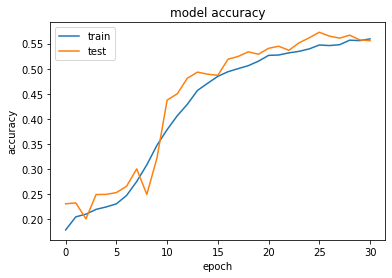

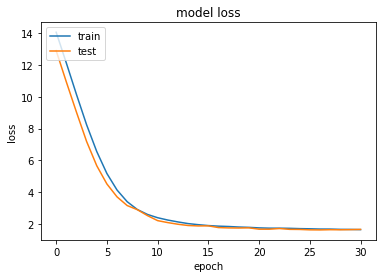

In [42]:
'''plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()'''

import matplotlib.pyplot as plt
%matplotlib inline
# list all data in training
print(history.history.keys())
# summarize training for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [43]:
test_loss,test_acc=model.evaluate(test_generator,verbose=3)
test_loss,test_acc

(1.6012753248214722, 0.5703538656234741)

In [44]:
predictions=model.predict(test_generator)

57/57 [==============================] - 1s 9ms/step


In [45]:
print(confusion_matrix(np.argmax(test_labels, axis = 1 ), np.argmax(model.predict(test_pixels),axis=1)))

113/113 [==============================] - 1s 6ms/step
[[199   0  18  46 121   8  99]
 [ 24   4   2   3  17   1   4]
 [ 60   0  71  60 185  56  96]
 [  9   0   7 751  51   8  53]
 [ 34   0  14  58 346   4 138]
 [  8   0  26  53  21 267  41]
 [ 13   0   6  40 153   5 409]]


In [46]:
print(classification_report(np.argmax(test_labels, axis = 1 ), np.argmax(model.predict(test_pixels),axis=1)))

113/113 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.57      0.41      0.47       491
           1       1.00      0.07      0.14        55
           2       0.49      0.13      0.21       528
           3       0.74      0.85      0.79       879
           4       0.39      0.58      0.47       594
           5       0.77      0.64      0.70       416
           6       0.49      0.65      0.56       626

    accuracy                           0.57      3589
   macro avg       0.64      0.48      0.48      3589
weighted avg       0.59      0.57      0.55      3589



### VGG16

In [29]:
a=np.zeros((28709,48,48,3))
b=np.zeros((3589,48,48,3))
c=np.zeros((3589,48,48,3))

for i in range(28709):
  for j in range(48):
    for k in range(48):
      a[i][j][k][0]=train_pixels[i][j][k][0]
      a[i][j][k][1]=train_pixels[i][j][k][0]
      a[i][j][k][2]=train_pixels[i][j][k][0]

for i in range(3589):
  for j in range(48):
    for k in range(48):
      b[i][j][k][0]=valid_pixels[i][j][k][0]
      b[i][j][k][1]=valid_pixels[i][j][k][0]
      b[i][j][k][2]=valid_pixels[i][j][k][0]

for i in range(3589):
  for j in range(48):
    for k in range(48):
      c[i][j][k][0]=test_pixels[i][j][k][0]
      c[i][j][k][1]=test_pixels[i][j][k][0]
      c[i][j][k][2]=test_pixels[i][j][k][0]
      

In [30]:
train_generator = traindatagen.flow(a, train_labels, batch_size=64)
val_generator = valgen.flow(b,valid_labels, batch_size=64)
test_generator=testgen.flow(c,test_labels,batch_size=64)

In [31]:
'''from keras import layers
from keras import applications
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model'''


input_shape = (48, 48, 3)
epochs = 40
batch_size = 32
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

In [32]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [33]:
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

model1 = Model(pre_trained_model.input, x)

In [34]:
model1.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [36]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 15),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [37]:
training = model1.fit(train_generator,
                   epochs=100,
                   validation_data=val_generator,
                   callbacks=[checkpointer])

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.6810 - accuracy: 0.3326
Epoch 1: val_accuracy improved from -inf to 0.39983, saving model to best_model.h5
449/449 [==============================] - 33s 66ms/step - loss: 1.6810 - accuracy: 0.3326 - val_loss: 1.5628 - val_accuracy: 0.3998
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5460 - accuracy: 0.4028
Epoch 2: val_accuracy improved from 0.39983 to 0.42602, saving model to best_model.h5
449/449 [==============================] - 28s 61ms/step - loss: 1.5460 - accuracy: 0.4028 - val_loss: 1.5039 - val_accuracy: 0.4260
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.4867 - accuracy: 0.4331
Epoch 3: val_accuracy improved from 0.42602 to 0.44302, saving model to best_model.h5
449/449 [==============================] - 28s 62ms/step - loss: 1.4867 - accuracy: 0.4331 - val_loss: 1.4736 - val_accuracy: 0.4430
Epoch 4/100
449/449 [==============================] - 

In [38]:
model_VGG16_json = model1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_VGG16_json)

model1.save_weights('model_VGG16_weights.h5')
model1.save('model_VGG16.h5')
print("[INFO] Saved model to disk")

[INFO] Saved model to disk


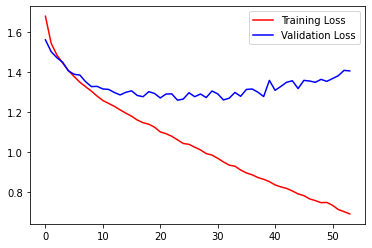

In [39]:
plt.plot(training.history["loss"],'r', label="Training Loss")
plt.plot(training.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [40]:
test_loss,test_acc=model1.evaluate(test_generator)
test_loss,test_acc

57/57 [==============================] - 1s 21ms/step - loss: 1.2255 - accuracy: 0.5812


(1.225479006767273, 0.5812203884124756)

In [41]:
predictions=model1.predict(c)

113/113 [==============================] - 2s 12ms/step


In [42]:
print(confusion_matrix(np.argmax(test_labels, axis = 1 ), np.argmax(model1.predict(c),axis=1)))

113/113 [==============================] - 1s 12ms/step
[[252   8  40  54  68   9  60]
 [ 10  36   2   3   0   0   4]
 [ 85   7 230  46  59  47  54]
 [ 52   1  32 706  27  15  46]
 [ 54   7  85  75 242  19 112]
 [ 23   2  49  32  10 282  18]
 [ 47   5  48  99  70  19 338]]


In [43]:
print(classification_report(np.argmax(test_labels, axis = 1 ), np.argmax(model1.predict(c),axis=1)))

113/113 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.48      0.51      0.50       491
           1       0.55      0.65      0.60        55
           2       0.47      0.44      0.45       528
           3       0.70      0.80      0.75       879
           4       0.51      0.41      0.45       594
           5       0.72      0.68      0.70       416
           6       0.53      0.54      0.54       626

    accuracy                           0.58      3589
   macro avg       0.57      0.58      0.57      3589
weighted avg       0.58      0.58      0.58      3589

